In [7]:
% setup environment
% clear data and number format
clear; format short e
% set path to equilibrium solver
txt=pwd; n=length(txt); rootpath=txt;
n=strfind(rootpath,"USERS"); rootpath=txt(1:n-2);
PHREEQCpath=[rootpath,'/runPHREEQC'];
addpath(PHREEQCpath);
JEQUILIBpath=[rootpath,'/JEQUILIB'];
addpath(JEQUILIBpath);
% turn off warnings
warning off
%graphics_toolkit ("notebook"); 
graphics_toolkit ("plotly"); 
%graphics_toolkit("gnuplot")
%delete existing phreeqc files
system("rm DATABASE.dat");
system("rm runfile.txt");
%create empty phreeqc files
system("touch DATABASE.dat");
system("touch runfile.txt");

# RESULT OF TESTING

**for tableau**

seems that only the logX with analytical derivatives works best.  I did find some situations that didn't converge.  so I added in some code to make more acidic and more oxic and step towards the answer that way.  doesn't seem to work but the idea is ok.  should check how I do this in the source search file returnspeciationRE or whatever it is called.

X based search didn't work though.  that's fine.  I could probably revise the search method but I like the log one better anyway.

**for PHREEQC**

error seem really big. 1e-6 error for hhigh pH and oxic case.

In [8]:
%%Note from CS to Scott: in your tableau, I was like: Hfos+ ; should be Hfow-, that generated big errors in PHREEQC because PHREEQC doesn't recognize Hfos+

In [9]:
% define equilibrium problem

%FeT=1e-5; PT=1e-4; NaT=3*PT; ClT=3*FeT; T=25; HFOsi=1e-30; HFOwi=1e-30; ASFw=1; ASFs=1; 
%pH=2:0.2:11; 
FeT=1e-5/0.997; PT=1e-5/0.997; NaT=3*PT; ClT=3*FeT; T=25; HFOsi=1e-30; HFOwi=1e-30; ASFw=0.2; ASFs=0.005; %/0.997 to mmol/kg at 25C
pH=2:0.2:12; 


% set redox level ------------------------
%peINT=20.75; %oxic
%peINT=15.75; %less oxic
%peINT=10.75; %getting reducing
peINT=5.75; %pretty reducing
%peINT=0; % maximum reducing

pe=peINT-pH;% oxic end


In [10]:
% MODEL USING TABLEAU (different gradients or log versus linear variables)
%graphics_toolkit("notebook")
%model with just inorganic speciation
%geochemical model
% input the constants and solution chemistry
flag0=1; %choose solver. 0 for tableau and 1 for phreeqc-based solver
flag1=2; %flag1 for concentration based search vector (1) or for log based search vector (2).
flag2=1; %flag2 for numerical derivatives (2) or analtyical derivatives (1)
flag3=0; % flag3 1 for show warnings. 0 no warnings
flag4=1; %if=1 solve tableau one line at a time to get a good initial guess (no solids). really challenging probs only
flag5=0; %if=1 use stored initial guess for including solids

TOTALS=[FeT; PT; ClT; NaT; HFOsi; HFOwi]';
TOTALS(TOTALS==0)=1e-16; % get rid of zero values, b/c div by zero error

for i=1:length(pH)
    flag5=0; % flags ignored for PHREEQC anyway.
    %if i>1; flag5=1; end
    [Fep3(i),HFO(i),HfowHPO4m(i),MASSERR(i)]=FeHPO4tableau(pH(i),pe(i),TOTALS',flag0,flag1,flag2,flag3,flag4,flag5); 
    if HFO(i)>0; % should make loop until HFO value converges, but from previous tests it converges fast.  one step was how I did the 2008 WER paper
        HFOs=ASFs*HFO(i); HFOw=ASFw*HFO(i); 
        TOTALS=[FeT; PT; ClT; NaT; HFOs; HFOw]';
        [Fep3(i),HFO(i),HfowHPO4m3(i),MASSERR(i)]=FeHPO4tableau(pH(i),pe(i),TOTALS',flag0,flag1,flag2,flag3,flag4,flag5);
    end
    dislay=[pH(i) Fep3(i) HFO(i) HfowHPO4m(i) MASSERR(i)]
end

dislay,1,2,3,4,5
1,2,5.37552e-15,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,2.2,3.3898e-15,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,2.4,2.13762e-15,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,2.6,1.34808e-15,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,2.8,8.50239e-16,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,3,5.36302e-16,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,3.2,3.38311e-16,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,3.4,2.13428e-16,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,3.6,1.3465e-16,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,3.8,8.49527e-17,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,4,5.35989e-17,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,4.2,3.38173e-17,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,4.4,2.13365e-17,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,4.6,1.34619e-17,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,4.8,8.49339e-18,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,5,5.35852e-18,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,5.2,3.38058e-18,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,5.4,2.13258e-18,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,5.6,1.34516e-18,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,5.8,8.48346e-19,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,6,5.34889e-19,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,6.2,3.37134e-19,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,6.4,2.1239e-19,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,6.6,1.33722e-19,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,6.8,8.41375e-20,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,7,5.29081e-20,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,7.2,3.22346e-20,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,7.4,1.48423e-20,0,1e-99,2.70812e-10


dislay,1,2,3,4,5
1,7.6,6.92347e-21,0,1e-99,2.70813e-10


dislay,1,2,3,4,5
1,7.8,3.26429e-21,0,1e-99,2.70813e-10


dislay,1,2,3,4,5
1,8,1.55038e-21,0,1e-99,2.70814e-10


dislay,1,2,3,4,5
1,8.2,7.39175e-22,0,1e-99,2.70818e-10


dislay,1,2,3,4,5
1,8.4,3.52697e-22,0,1e-99,2.70828e-10


dislay,1,2,3,4,5
1,8.6,1.68046e-22,0,1e-99,2.70857e-10


dislay,1,2,3,4,5
1,8.8,7.98293e-23,0,1e-99,2.70948e-10


dislay,1,2,3,4,5
1,9,3.77685e-23,0,1e-99,2.71236e-10


dislay,1,2,3,4,5
1,9.2,1.77719e-23,0,1e-99,2.72144e-10


dislay,1,2,3,4,5
1,9.4,4.9091e-24,8.90928e-06,1e-99,2.62695e-10


dislay,1,2,3,4,5
1,9.6,1.23311e-24,9.83194e-06,1.58255e-08,2.66518e-10


dislay,1,2,3,4,5
1,9.8,3.09744e-25,9.84287e-06,1.44691e-08,2.71609e-10


dislay,1,2,3,4,5
1,10,7.78044e-26,9.79283e-06,9.16496e-09,2.74323e-10


dislay,1,2,3,4,5
1,10.2,1.95436e-26,9.68667e-06,5.76323e-09,2.7531e-10


dislay,1,2,3,4,5
1,10.4,4.90916e-27,9.50775e-06,3.60072e-09,2.75597e-10


dislay,1,2,3,4,5
1,10.6,1.23313e-27,9.21993e-06,2.23156e-09,2.75604e-10


dislay,1,2,3,4,5
1,10.8,3.09753e-28,8.76206e-06,1.36596e-09,2.75438e-10


dislay,1,2,3,4,5
1,11,7.78079e-29,8.03573e-06,8.19276e-10,2.75092e-10


dislay,1,2,3,4,5
1,11.2,1.95451e-29,6.88432e-06,4.74149e-10,2.74498e-10


dislay,1,2,3,4,5
1,11.4,4.90973e-30,5.05939e-06,2.56343e-10,2.7353e-10


dislay,1,2,3,4,5
1,11.6,1.23336e-30,2.16716e-06,1.18874e-10,2.71979e-10


dislay,1,2,3,4,5
1,11.8,2.49688e-31,0,3.21282e-11,2.70812e-10


dislay,1,2,3,4,5
1,12,3.96125e-32,0,2.02721e-11,2.70812e-10


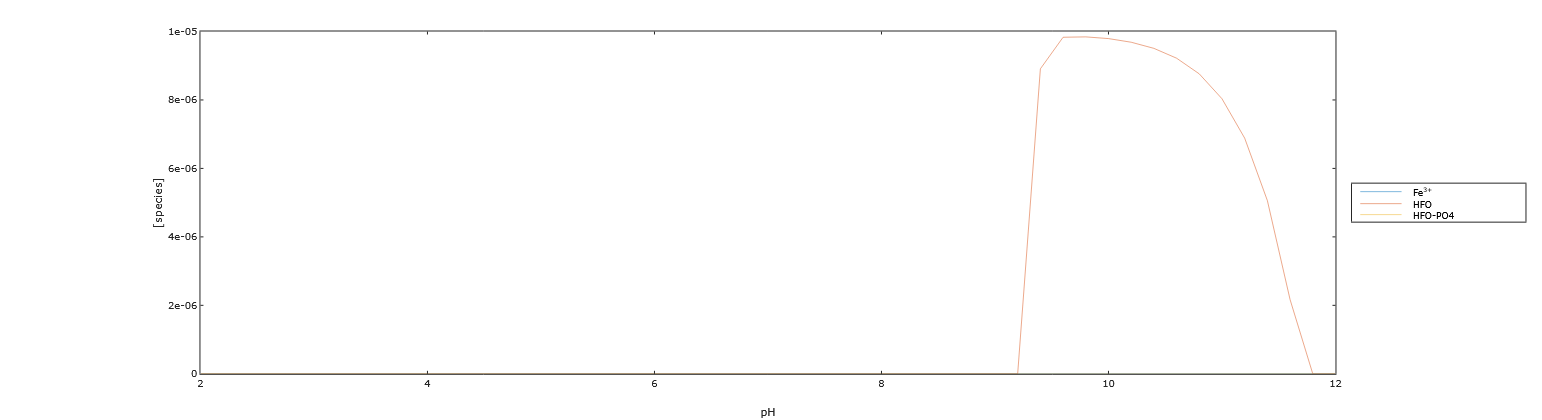

In [11]:

plot(pH,Fep3,pH,HFO,pH,HfowHPO4m)
xlabel('pH'); ylabel('[species]'); legend('Fe^{3+}','HFO','HFO-PO4','location','eastoutside')



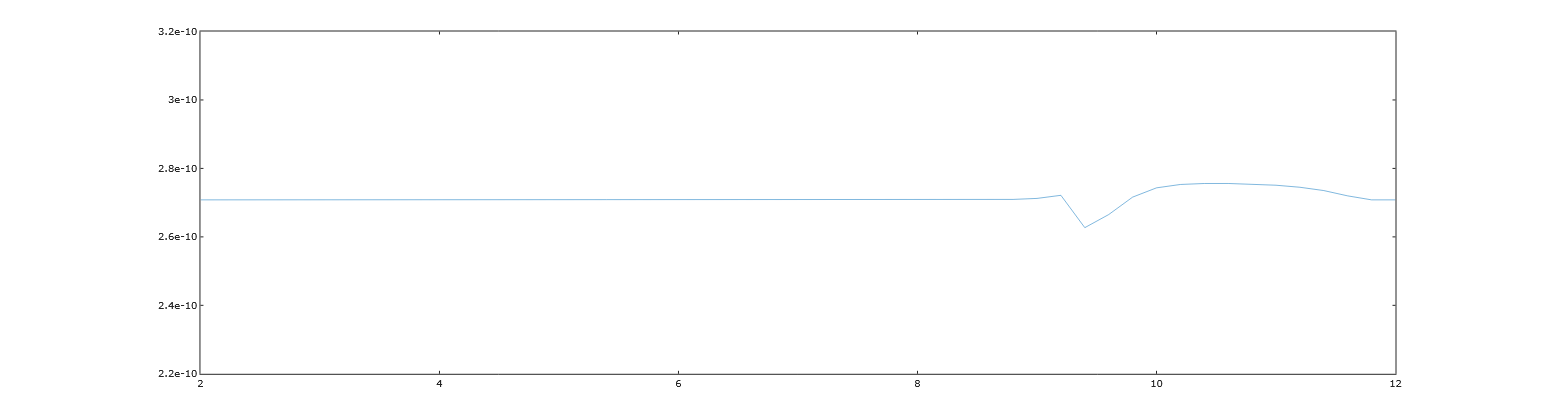

In [12]:
plot(pH,MASSERR)

In [7]:
% === GUARDAR RESULTADOS DE ESTA SESIÓN ==================
quickRun = struct( ...
    "pH",          pH(:),        ...
    "Fe3_aq",      Fep3(:),      ...
    "FeOH3s",      HFO(:),       ...
    "HFO_P_ads",   HfowHPO4m(:), ...
    "MassErr",     MASSERR(:)    ...
);
save("-v7", "phreeqc_runs.mat", "quickRun");
printf("\nquickRun guardado con los datos de la sesión rápida.\n");


quickRun guardado con los datos de la sesión rápida.


In [ ]:
%% ==============================================================
%% 1. Helper robusto: extrae el CPU-time de out.txt
%% ==============================================================
function t = get_cpu_time (fname)
  t = NaN;
  fid = fopen (fname,"rb");
  if fid < 0, warning ("No pude abrir %s", fname); return; end
  data = fread (fid, Inf, "uint8=>uint8");  fclose (fid);
  data(data>127) = 32;                       % limpia UTF-8 raro
  str = char (data');
  tok = regexp (str,"after\\s+([0-9.]+(?:[eE][+-]?[0-9]+)?)\\s+Seconds",
                "tokens","once");
  if !isempty(tok), t = str2double(tok{1}); end
endfunction


%% ==============================================================
%% 2. Bucle principal — resultados + tiempos
%% ==============================================================
if exist("phreeqc_runs_times.mat","file"), delete("phreeqc_runs_times.mat"); endif
nRuns = 50;
save("-v7","phreeqc_runs_times.mat","nRuns");          % cabecera mínima

nPts = numel(pH);

% ===== matrices para TODAS las corridas =====
Fep3        = NaN(nPts,nRuns);   % Fe3+ (aq)
HFO         = NaN(nPts,nRuns);   % Fe(OH)3(s)
HFO_PO4     = NaN(nPts,nRuns);   % HfowHPO4m  (P adsorbido)
MassErr     = NaN(nPts,nRuns);   % error global de masa

t_wall = NaN(nRuns,1);
t_cpu  = NaN(nRuns,1);

for run = 1:nRuns
  tic();
  for i = 1:nPts
    flag5 = 0;
    [Fep3(i,run), HFO(i,run), HFO_PO4(i,run), MassErr(i,run)] = ...
        FeHPO4tableau(pH(i), pe(i), TOTALS', ...
                      flag0, flag1, flag2, flag3, flag4, flag5);

    if HFO(i,run) > 0                         % 2ª pasada si hay HFO
      HFOs   = ASFs * HFO(i,run);
      HFOw   = ASFw * HFO(i,run);
      TOTALS = [FeT; PT; ClT; NaT; HFOs; HFOw]';
      [Fep3(i,run), HFO(i,run), HFO_PO4(i,run), MassErr(i,run)] = ...
          FeHPO4tableau(pH(i), pe(i), TOTALS', ...
                        flag0, flag1, flag2, flag3, flag4, flag5);
    endif
  endfor

  t_wall(run) = toc();
  t_cpu(run)  = get_cpu_time("out.txt");

  % ---------- guardado especial en la 1ª corrida ----------
  if run == 1
    firstRun = struct( ...
        "pH",        pH(:),      ...
        "FeOH3s",    HFO(:,1),   ...
        "Fe3_aq",    Fep3(:,1),  ...
        "HFO_P_ads", HFO_PO4(:,1) );
    MassErr_firstRun = MassErr(:,1);

    save("-v7","-append","phreeqc_runs_times.mat", ...
         "firstRun","MassErr_firstRun");
    printf("\nGuardado firstRun + MassErr_firstRun tras run = 1.\n");
  endif

  printf("Run %02d | wall = %.3f s | cpu = %.3f s  -> guardado\n",
         run, t_wall(run), t_cpu(run));

  % ---- guardado incremental: solo tiempos + run ----
  save("-v7","-append","phreeqc_runs_times.mat","t_wall","t_cpu","run");
  fflush(stdout);
endfor


%% ==============================================================
%% 3. Estadísticos finales y cierre
%% ==============================================================
valid_wall = t_wall(~isnan(t_wall));
valid_cpu  = t_cpu(~isnan(t_cpu));

stats.wall_mean = mean(valid_wall);
stats.wall_std  = std (valid_wall);
stats.cpu_mean  = mean(valid_cpu);
stats.cpu_std   = std (valid_cpu);

save("-v7","-append","phreeqc_runs_times.mat","stats");

printf("\n>> ¡Todo completo! firstRun, tiempos y estadísticos guardados.\n");



Guardado firstRun + MassErr_firstRun tras run = 1.
Run 01 | wall = 15.540 s | cpu = 0.005 s  -> guardado
Run 02 | wall = 15.612 s | cpu = 0.006 s  -> guardado
Run 03 | wall = 15.647 s | cpu = 0.005 s  -> guardado
Run 04 | wall = 15.683 s | cpu = 0.005 s  -> guardado
Run 05 | wall = 15.797 s | cpu = 0.005 s  -> guardado
Run 06 | wall = 15.784 s | cpu = 0.005 s  -> guardado
Run 07 | wall = 15.778 s | cpu = 0.005 s  -> guardado
Run 08 | wall = 16.091 s | cpu = 0.005 s  -> guardado
Run 09 | wall = 16.069 s | cpu = 0.005 s  -> guardado
Run 10 | wall = 15.967 s | cpu = 0.005 s  -> guardado
